In [19]:
import numpy as np
from scipy.io import loadmat
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib

Step 1

In [20]:
def initialize_parameters(hidden_size, visible_size):
    r  = np.sqrt(6) / np.sqrt(hidden_size + visible_size + 1)
    W1 = np.random.random((hidden_size, visible_size)) * 2.0 * r - r
    W2 = np.random.random((visible_size, hidden_size)) * 2.0 * r - r
    b1 = np.zeros(hidden_size)
    b2 = np.zeros(visible_size)
    theta = np.hstack((W1.ravel(), W2.ravel(), b1.ravel(), b2.ravel()))
    return theta

def display_network(A):
    opt_normalize = True
    opt_graycolor = True

    A = A - np.average(A)

    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    n = np.ceil(np.sqrt(col))
    m = np.ceil(col / n)
    
    img_shape1 = int(buf + m * (sz + buf))
    img_shape2 = int(buf + n * (sz + buf))
    image = np.ones(shape=(img_shape1, img_shape2))

    if not opt_graycolor:
        image *= 0.1

    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1
    return image

def load_MNIST_images(filename):
    with open(filename, "r") as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        n_images = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        rows = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        cols = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        images = np.fromfile(f, dtype=np.ubyte)
        images = images.reshape((int(n_images), int(rows * cols)))
        images = images.T
        images = images.astype(np.float64) / 255

        f.close()

        return images

def load_MNIST_labels(filename):
    with open(filename, 'r') as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        n_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        labels = np.fromfile(f, dtype=np.uint8)

        f.close()

        return labels

In [21]:
print load_MNIST_images('train-images-idx3-ubyte')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Step 2

In [22]:

def sigmoid(z2):
    return 1/(1 + np.exp(-1*z2))

def sparse_autoencoder_cost(theta, visible_size, hidden_size, lambda_, sparsity_param, beta, data):
    W1 = theta[:visible_size*hidden_size].reshape((hidden_size, visible_size))
    W2 = theta[visible_size*hidden_size:2*hidden_size*visible_size].reshape((visible_size, hidden_size))
    b1 = theta[2*hidden_size*visible_size:2*hidden_size*visible_size+hidden_size]
    b2 = theta[2*hidden_size*visible_size+hidden_size:]
    
    m = data.shape[1]
    
    a1 = data
    z2 = W1.dot(a1) + b1.reshape((-1, 1))
    a2 = sigmoid(z2)
    z3 = W2.dot(a2) + b2.reshape((-1, 1))
    a3 = sigmoid(z3)
    h = a3
    y = a1
    
    rho = sparsity_param
    rho_hat = np.mean(a2, axis = 1)
    sparsity_delta = (-rho/rho_hat + (1.0 - rho)/(1.0 - rho_hat)).reshape((-1,1))
    
    delta3 = (h-y)*h*(1.0-h)
    delta2 = (W2.T.dot(delta3) + beta*sparsity_delta)*a2*(1.0-a2)
    
    squared_error_term = np.sum((h-y)**2)/(2.0*m)
    weight_decay = 0.5*lambda_*(np.sum(W1*W1) + np.sum(W2*W2))
    sparsity_term = beta*np.sum(rho*np.log(rho/rho_hat) + (1.0-rho)*np.log((1.0-rho)/(1.0-rho_hat)))
    cost = squared_error_term + weight_decay + sparsity_term
    
    W2_grad = delta3.dot(a2.T)/m + lambda_*W2
    W1_grad = delta2.dot(a1.T)/m + lambda_*W1
    b1_grad = np.mean(delta2, axis = 1)
    b2_grad = np.mean(delta3, axis = 1)
    grad = np.hstack((W1_grad.ravel(), W2_grad.ravel(), b1_grad, b2_grad))
    
    return cost, grad

Step 3

In [23]:
def simple_quadratic_function(x):
    value = x[0]*x[0] + 3*x[0]*x[1]
    grad = np.zeros(2)
    grad[0] = 2*x[0] + 3*x[1]
    grad[1] = 3*x[0]
    return value, grad

def compute_numerical_gradient(J, theta):
    n = theta.size
    grad = np.zeros(n)
    eps = 1.0e-4
    eps2 = 2*eps
    
    for i in range(n):
        theta_p = theta.copy()
        theta_n = theta.copy()
        theta_p[i] = theta[i] + eps
        theta_n[i] = theta[i] - eps
        grad[i] = (J(theta_p) - J(theta_n)) / eps2
    return grad

def check_numerical_gradient():
    x = np.array([4, 10], dtype = np.float64)
    value, grad = simple_quadratic_function(x)
    func = lambda x: simple_quadratic_function(x)[0]
    numgrad = compute_numerical_gradient(func, x)
    
    n_grad = grad.size
    for i in range(n_grad):
        print "{0:20.12f} {1:20.12f}".format(numgrad[i], grad[i])
    print 'The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)\n'

    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print "Norm of difference = ", diff
    print 'Norm of the difference between numerical and analytical gradient (should be < 1e-9)\n\n'

In [24]:
check_numerical_gradient()

     37.999999999982      38.000000000000
     11.999999999830      12.000000000000
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

Norm of difference =  2.1452381569477388e-12
Norm of the difference between numerical and analytical gradient (should be < 1e-9)




Train our network with MNIST data

Show the results of optimization as following.

      fun: 12.116999524175744
 hess_inv: <308308x308308 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.02137266e-06, 3.14655306e-07, 1.98872782e-07, ...,
       2.71043293e-05, 2.70859156e-05, 2.71554439e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 417
      nit: 400
   status: 1
  success: False
        x: array([ 3.40457554e-04,  1.04885102e-04,  6.62909273e-05, ...,
       -5.22170978e+00, -5.22185820e+00, -5.22126804e+00])


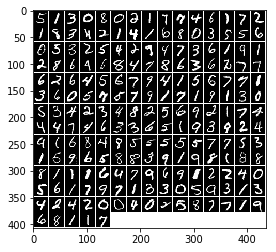

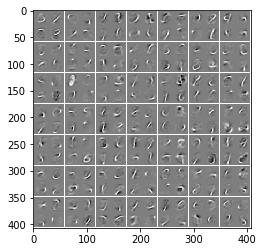

In [27]:
# Loading 10K images from MNIST database
images = load_MNIST_images('train-images-idx3-ubyte')
patches = images[:, :10000]

n_patches = patches.shape[1]

# Randomly sample 200 patches and save as an image file
image = display_network(patches[:, [np.random.randint(n_patches) for i in range(200)]])

plt.figure()
plt.imsave('sparse_autoencoder_minist_patches.png', image, cmap=plt.cm.gray)
plt.imshow(image, cmap=plt.cm.gray)

visible_size = patches.shape[0] # Number of input units
hidden_size = 196               # Number of hidden units

weight_decay_param = 3e-3       # Weight decay parameter, which is the lambda in lecture notes
beta = 3                        # Weight of sparsity penalty term
sparsity_param = 0.1            # Desired average activation of the hidden units.

#  Randomly initialize the fitting parameters
theta = initialize_parameters(hidden_size, visible_size)

J = lambda theta : sparse_autoencoder_cost(theta, visible_size, hidden_size, weight_decay_param, sparsity_param, beta, patches)

# The number of maximun iterations is set as 400,
# which is good enough to get reasonable results.
options = {'maxiter': 400, 'disp': True, 'gtol': 1e-5, 'ftol': 2e-9}
results = scipy.optimize.minimize(J, theta, method='L-BFGS-B', jac=True, options=options)
opt_theta = results['x']

print("Show the results of optimization as following.\n")
print(results)

# Visualization
W1 = opt_theta[0:hidden_size*visible_size].reshape((hidden_size, visible_size))

image = display_network(W1.T)
plt.figure()
plt.imsave('sparse_autoencoder_minist_weights.png', image, cmap=plt.cm.gray)
plt.imshow(image, cmap=plt.cm.gray)

plt.show()